<a href="https://colab.research.google.com/github/mofuoku417/Multivariate-Time-Series-Forecasting-of-Crude-Palm-Oil-Price-Using-Machine-Learning-Techniques/blob/main/MLP_RegressionC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Objective
The goal of this study is to apply Multi-Layer Perceptron Regression to predict monthly crude oil price.

###Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime
from sklearn.svm import SVR
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from numpy import concatenate
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [ ]:
#To compute Mean Directional Accuracy
def mda(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Directional Accuracy """
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])).astype(int))

#Calculate the root mean squared error:
def RMSE(y_true, y_pred): 
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

#Calculate the mean absolute percentage error
def MAPE(y_true, y_pred): 
    mape = np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / np.array(y_true))) * 100
    return mape

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
#reading the csv file into pandas data frame
df = pd.read_csv("/content/gdrive/MyDrive/raw_data/df3.csv")
date_rng = pd.date_range(start='2002-02-28', end='2021-03-31', freq='M')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230 entries, 0 to 229
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  230 non-null    int64  
 1   Month       230 non-null    object 
 2   cpo_pri     230 non-null    int64  
 3   cno_pri     230 non-null    int64  
 4   sbo_pri     230 non-null    float64
 5   pno_pri     230 non-null    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 10.9+ KB


In [ ]:
df['Month'] = df['Month'].apply(pd.to_datetime)
df['TimeIndex'] = pd.DataFrame(date_rng, columns=['Month'])

In [ ]:
del df['Unnamed: 0']

In [ ]:
del df['Month']

In [ ]:
df.head()

,cpo_pri,cno_pri,sbo_pri,pno_pri,TimeIndex
0,323,455,468.0,844.0,2002-02-28
1,345,546,485.0,799.0,2002-03-31
2,362,595,466.0,718.0,2002-04-30
3,376,636,442.0,614.0,2002-05-31
4,383,738,429.0,619.0,2002-06-30


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230 entries, 0 to 229
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   cpo_pri    230 non-null    int64         
 1   cno_pri    230 non-null    int64         
 2   sbo_pri    230 non-null    float64       
 3   pno_pri    230 non-null    float64       
 4   TimeIndex  230 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 9.1 KB


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f914944ef10>,
      dtype=object)

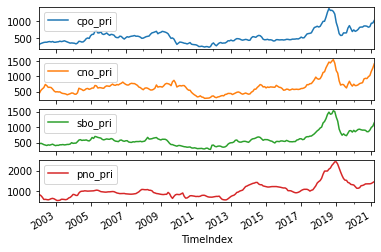

In [ ]:
df.set_index('TimeIndex')[['cpo_pri', 'cno_pri','sbo_pri', 'pno_pri']].plot(subplots=True)

In [ ]:
df.set_index('TimeIndex')

,cpo_pri,cno_pri,sbo_pri,pno_pri
TimeIndex,,,,
2002-02-28,323,455,468.00,844.00
2002-03-31,345,546,485.00,799.00
2002-04-30,362,595,466.00,718.00
2002-05-31,376,636,442.00,614.00
2002-06-30,383,738,429.00,619.00
...,...,...,...,...
2020-11-30,826,993,860.28,1366.87
2020-12-31,844,1031,910.82,1366.87
2021-01-31,944,1170,997.62,1383.90


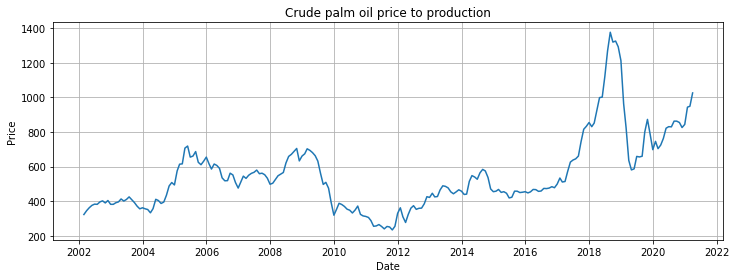

In [ ]:
plt.figure(figsize=(12,4))
plt.grid()
plt.plot(df.TimeIndex, df.cpo_pri)
plt.title('Crude palm oil price to production')
plt.ylabel('Price')
plt.xlabel('Date')
plt.show()

In [ ]:
split_date = '2017-06'
df_training = df.loc[df.TimeIndex <= split_date]
df_test = df.loc[df.TimeIndex > split_date]
print(f"{len(df_training)} days of training data \n {len(df_test)} days of testing data ")

184 days of training data 
 46 days of testing data 


In [ ]:
# ADD time features to our model
def create_time_features(df, target=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    X = df.drop(['date'], axis=1)
    if target:
        y = df[target]
        X = X.drop([target], axis=1)
        return X, y

    return X

In [ ]:
x = df[['cno_pri', 'sbo_pri', 'pno_pri']]
y = df[['cpo_pri']]

In [ ]:
#y = np.reshape(y, (-1,1))

In [ ]:
scaler_x = MinMaxScaler()   
scaler_y = MinMaxScaler()
print(scaler_x.fit(x))       
xscale=scaler_x.transform(x)
print(scaler_y.fit(y))               
yscale=scaler_y.transform(y)

MinMaxScaler(copy=True, feature_range=(0, 1))
MinMaxScaler(copy=True, feature_range=(0, 1))


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(xscale, yscale, test_size=0.2, random_state=0)
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [ ]:
pipe_MLPRegressor = Pipeline([('scaler',  MinMaxScaler()),
            ('MLPRegressor', MLPRegressor(random_state = 42))])

In [ ]:
grid_params_MLPRegressor = [{
    'MLPRegressor__solver': ['sgd', 'adam'],
    'MLPRegressor__alpha': [0.0001, 0.05],
    'MLPRegressor__max_iter': [100,200,300, 500, 1000],
    'MLPRegressor__activation' : ['relu','logistic','tanh'],
    'MLPRegressor__learning_rate' : ['constant', 'adaptive'],
    'MLPRegressor__hidden_layer_sizes':[(50,50,50), (50,100,50), (100,)],}]


CV_mlpregressor_grid = GridSearchCV (estimator = pipe_MLPRegressor,
                               param_grid = grid_params_MLPRegressor, n_jobs=-1,
                               cv = 5,return_train_score=True, verbose=0)


CV_mlpregressor_grid.fit(X_train, y_train)

ypred=CV_mlpregressor_grid.predict(X_test)

print (np.c_[y_test, ypred])
print('Train Accuracy : %.3f'%CV_mlpregressor_grid.best_estimator_.score(X_train, y_train))
print('Test Accuracy : %.3f'%CV_mlpregressor_grid.best_estimator_.score(X_test, y_test))
print('Best Accuracy Through Grid Search : %.3f'%CV_mlpregressor_grid.best_score_)
print('Best Parameters : ',CV_mlpregressor_grid.best_params_)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1342: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[0.18285214 0.16706424]
 [0.92650919 0.96308364]
 [0.07786527 0.071098  ]
 [0.3735783  0.37828687]
 [0.20297463 0.18806102]
 [0.13473316 0.19387831]
 [0.4295713  0.43830963]
 [0.29046369 0.26559903]
 [0.52143482 0.47101078]
 [0.20384952 0.23117992]
 [0.24584427 0.23222372]
 [0.02712161 0.05141235]
 [0.29133858 0.28001992]
 [0.13648294 0.17330945]
 [0.167979   0.12447179]
 [0.19247594 0.16435065]
 [0.08573928 0.12645769]
 [0.12948381 0.17589809]
 [0.32983377 0.25956117]
 [0.18547682 0.26126671]
 [0.23184602 0.26585735]
 [0.04724409 0.04835914]
 [0.37182852 0.39875221]
 [0.55905512 0.47422448]
 [0.0183727  0.05022551]
 [0.28608924 0.27286609]
 [0.20734908 0.27792768]
 [0.33420822 0.28751023]
 [0.13735783 0.12341991]
 [0.17935258 0.16556883]
 [0.24234471 0.26477407]
 [0.22047244 0.18790714]
 [0.54330709 0.50254161]
 [0.28696413 0.30102899]
 [0.21084864 0.25063656]
 [0.15223097 0.11113756]
 [0.14610674 0.12004486]
 [0.24496938 0.27814347]
 [0.14698163 0.16658682]
 [0.12860892 0.18438992]


In [ ]:
model = Sequential()
model.add(Dense(12, input_dim=3, kernel_initializer='normal', activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 12)                48        
                                                                 
 dense_4 (Dense)             (None, 8)                 104       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 161
Trainable params: 161
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])

In [ ]:
history = model.fit(X_train, y_train, epochs=250, batch_size=50,  verbose=1, validation_split=0.2)

Epoch 1/250
3/3 [==============================] - 1s 82ms/step - loss: 0.1089 - mse: 0.1089 - mae: 0.2694 - val_loss: 0.1348 - val_mse: 0.1348 - val_mae: 0.3151
Epoch 2/250
3/3 [==============================] - 0s 14ms/step - loss: 0.1000 - mse: 0.1000 - mae: 0.2557 - val_loss: 0.1263 - val_mse: 0.1263 - val_mae: 0.3035
Epoch 3/250
3/3 [==============================] - 0s 15ms/step - loss: 0.0941 - mse: 0.0941 - mae: 0.2456 - val_loss: 0.1198 - val_mse: 0.1198 - val_mae: 0.2940
Epoch 4/250
3/3 [==============================] - 0s 14ms/step - loss: 0.0886 - mse: 0.0886 - mae: 0.2359 - val_loss: 0.1136 - val_mse: 0.1136 - val_mae: 0.2844
Epoch 5/250
3/3 [==============================] - 0s 15ms/step - loss: 0.0833 - mse: 0.0833 - mae: 0.2254 - val_loss: 0.1069 - val_mse: 0.1069 - val_mae: 0.2733
Epoch 6/250
3/3 [==============================] - 0s 16ms/step - loss: 0.0779 - mse: 0.0779 - mae: 0.2138 - val_loss: 0.0995 - val_mse: 0.0995 - val_mae: 0.2608
Epoch 7/250
3/3 [===========

dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])


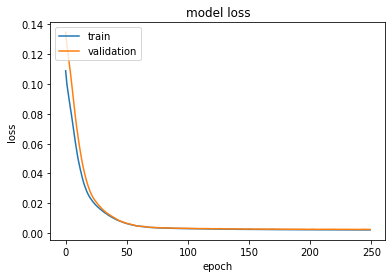

In [ ]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
ypred = model.predict(X_test)

In [ ]:
mlp_pred = scaler_y.inverse_transform(ypred)

In [ ]:
MLP_predictions = pd.DataFrame(mlp_pred, columns = ['Predictions'])

In [ ]:
MLP_predictions.head()

,Predictions
0,418.773621
1,1363.503052
2,326.109131
3,645.592224
4,439.569336


In [ ]:
testY = scaler_y.inverse_transform(y_test)

In [ ]:
testY2 = pd.DataFrame(testY, columns = ['Predictions'])

In [ ]:
testY2.head()

,Predictions
0,443.0
1,1293.0
2,323.0
3,661.0
4,466.0


In [ ]:
ActPred = pd.DataFrame(np.concatenate([testY, mlp_pred], axis=1), columns= ['Actual','MLP Predicted'])

In [ ]:
ActPred 

,Actual,MLP Predicted
0,443.0,418.773621
1,1293.0,1363.503052
2,323.0,326.109131
3,661.0,645.592224
4,466.0,439.569336
5,388.0,451.841614
6,725.0,715.716125
7,566.0,519.049377
8,830.0,759.385925
9,467.0,482.655182


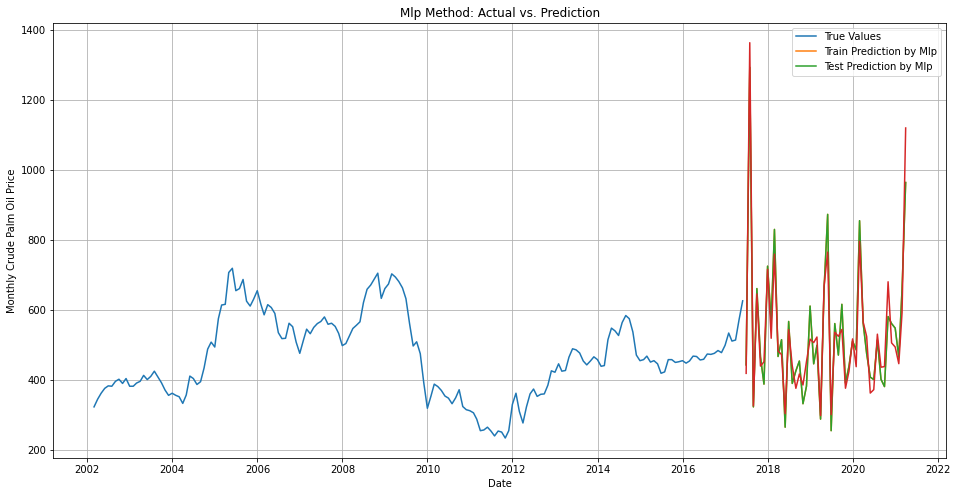

In [ ]:
plt.figure(figsize=(16,8))
plt.grid()
plt.plot(df_training.TimeIndex, df_training.cpo_pri, label = 'Train')
plt.plot(df_test.TimeIndex, testY2,  label = 'Test')
plt.plot(df_test.TimeIndex, ActPred,label = 'MLP Prediction')
plt.legend(['True Values', 'Train Prediction by Mlp', 'Test Prediction by Mlp'],loc='best')
plt.title('Mlp Method: Actual vs. Prediction')
plt.ylabel('Monthly Crude Palm Oil Price')
plt.xlabel('Date')
plt.show()

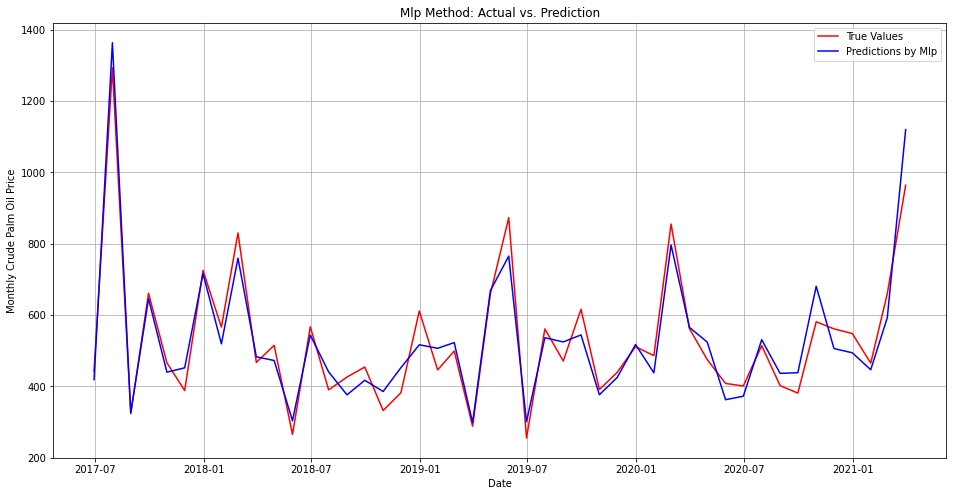

In [ ]:
plt.figure(figsize=(16,8))
plt.grid()
plt.plot(df_test.TimeIndex, testY2, color = 'red',  label = 'Test')
plt.plot(df_test.TimeIndex,  MLP_predictions, color = 'blue',label = 'MLP Prediction')
plt.legend(['True Values', 'Predictions by Mlp', 'MLP Prediction'],loc='best')
plt.title('Mlp Method: Actual vs. Prediction')
plt.ylabel('Monthly Crude Palm Oil Price')
plt.xlabel('Date')
plt.show()

In [ ]:
MAE_mlp = mean_absolute_error(testY2, MLP_predictions)
print('MAE value of the MLP Model is:', MAE_mlp)

MDA_mlp = mda(testY2, MLP_predictions)
print("MDA value of the MLP Model is:", *MDA_mlp)

MAPE_mlp = mean_absolute_percentage_error(testY2, MLP_predictions)
print('MAPE value of the MLP Model is:', MAPE_mlp)

RMSE_mlp = mean_squared_error(testY2, MLP_predictions, squared=False)
print('RMSE value of the MLP Model is:', RMSE_mlp)

MSE_mlp = mean_squared_error(testY2, MLP_predictions)
print('MSE value of the MLP Model is:', MSE_mlp)

MAE value of the MLP Model is: 44.3713146707286
MDA value of the MLP Model is: 0.9565217391304348
MAPE value of the MLP Model is: 8.625042333088063
RMSE value of the MLP Model is: 53.80412557919221
MSE value of the MLP Model is: 2894.8839293414853
